In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from sklearn import gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from fourier_2d import *
from util import *

In [2]:
curr = generate(samples=2*1000,out_dim=51,length_scale=0.2)
N = curr.shape[0]//2
grid = np.linspace(0,1,51)
f = np.zeros((N,grid.shape[0],grid.shape[0]))
f0 = np.zeros((N,grid.shape[0],grid.shape[0]))+1
u = np.zeros((N,grid.shape[0],grid.shape[0]))
u0 = np.zeros((N,grid.shape[0],grid.shape[0]))
for i in range(N):
    f[i] = generate_2(curr[i*2],curr[i*2+1])
    u[i] = FD_2d(f[i],grid)
    if i==0:
        u0[i] = FD_2d(f0[i],grid)
    else:
        u0[i] = u0[0]
    print('\rGenerating u: {:d}/{:d}'.format(i+1,N), end='', flush=True)
    
f_aug = 1*f+10
u_aug = 1*u+10*u0
f_aug = np.concatenate((f,f_aug))
u_aug = np.concatenate((u,u_aug))

ntest = 60
curr_1 = generate(samples=2*ntest,out_dim=51,length_scale=0.2)
curr_2 = generate(samples=2*ntest,out_dim=51,length_scale=2)
curr_3 = generate(samples=2*ntest,out_dim=51,length_scale=0.2,A=10)
curr_4 = generate(samples=2*ntest,out_dim=51,length_scale=2,A=10)
curr = np.concatenate((curr_1,curr_2))
curr = np.concatenate((curr,curr_3))
curr = np.concatenate((curr,curr_4))
N = curr.shape[0]//2
f_test = np.zeros((N,grid.shape[0],grid.shape[0]))
u_test = np.zeros((N,grid.shape[0],grid.shape[0]))
for i in range(N):
    f_test[i] = generate_2(curr[i*2],curr[i*2+1])
    u_test[i] = FD_2d(f_test[i],grid)
    print('\rGenerating u: {:d}/{:d}'.format(i+1,N), end='', flush=True)

Generating u: 240/24000

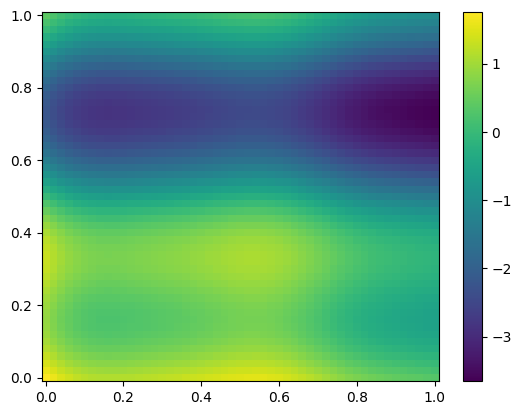

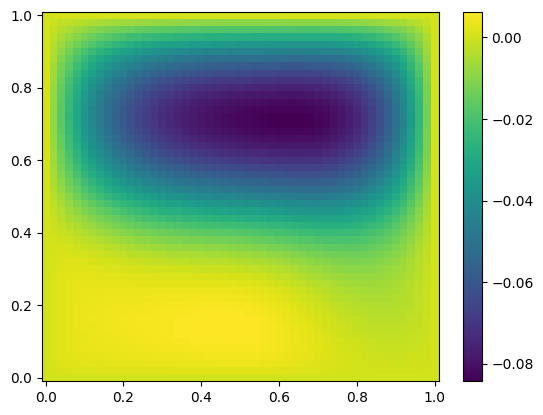

In [3]:
X, Y = np.meshgrid(grid, grid)
plt.pcolormesh(Y, X, f[0], shading='auto')
plt.colorbar()
plt.show()
plt.pcolormesh(Y, X, u[0], shading='auto')
plt.colorbar()
plt.show()

In [4]:
ntrain = 1000
naug = 2000
ntest = 60

batch_size = 20
learning_rate = 0.001
epochs = 600
step_size = 100
gamma = 0.5
modes1 = 12
modes2 = 12
width = 16

f_train = torch.Tensor(f)
u_train = torch.Tensor(u)
f_test = torch.Tensor(f_test)
u_test = torch.Tensor(u_test)
f_aug = torch.Tensor(f_aug)
u_aug = torch.Tensor(u_aug)
f_train = torch.reshape(f_train,(f_train.shape[0],f_train.shape[1],f_train.shape[2],1))
f_test = torch.reshape(f_test,(f_test.shape[0],f_test.shape[1],f_test.shape[2],1))
f_aug = torch.reshape(f_aug,(f_aug.shape[0],f_aug.shape[1],f_aug.shape[2],1))
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_train, u_train), batch_size=batch_size, shuffle=True)
aug_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_aug, u_aug), batch_size=batch_size, shuffle=True)
test_1_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[:ntest], u_test[:ntest]), batch_size=1, shuffle=False)
test_2_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[ntest:ntest*2], u_test[ntest:ntest*2]), batch_size=1, shuffle=False)
test_3_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[ntest*2:ntest*3], u_test[ntest*2:ntest*3]), batch_size=1, shuffle=False)
test_4_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(f_test[ntest*3:], u_test[ntest*3:]), batch_size=1, shuffle=False)

model = FNO2d(modes1, modes2, width).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 592129
epoch 600/600 L2 = 0.002929, MSE = 0.000000, using 0.680939sTotal training time: 389.96365639999993 s


In [5]:
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_1_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_1_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_2_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_2_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_3_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_3_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_4_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_4_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
torch.save(model,'model/fno2_1')

test error: L2 = 0.002773705107392743 , MSE = 4.6966126058626637e-08
test error: L2 = 0.002200951217673719 , MSE = 6.8933335766370915e-09
test error: L2 = 0.22733261361718177 , MSE = 0.009743087426371252
test error: L2 = 0.21714977410932382 , MSE = 0.008352687749720644


In [6]:
model = FNO2d(modes1, modes2, width).cuda()
print('Total parameters:',count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
start = default_timer()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in aug_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    scheduler.step()
    train_mse /= len(aug_loader)
    train_l2 /= naug
    t2 = default_timer()
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='', flush=True)

print('Total training time:',default_timer()-start,'s')

test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_1_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_1_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_2_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_2_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_3_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_3_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)
    
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_4_loader:
        x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
    test_mse /= len(test_4_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

Total parameters: 592129
epoch 600/600 L2 = 0.001918, MSE = 0.000000, using 1.285090sTotal training time: 787.2601039 s
test error: L2 = 0.002761816334289809 , MSE = 2.8029901818123668e-08
test error: L2 = 0.005440889966363708 , MSE = 7.2176965367395004e-09
test error: L2 = 0.0007858891806487615 , MSE = 1.2166858184651612e-07
test error: L2 = 0.0006823799247892263 , MSE = 7.338516153273152e-08


In [7]:
torch.save(model,'model/fno2_2')